# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [2]:
import cv2
import os
import numpy as np 
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf



In [3]:
!pip install scikit-image



In [4]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
plt.rcParams["figure.figsize"] = (20,6)

In [5]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

tar: Error opening archive: Failed to open '/root/.keras/datasets/simpsons_train.tar.gz'


In [6]:
# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

tar: Error opening archive: Failed to open '/root/.keras/datasets/simpsons_test.tar.gz'


In [7]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [8]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [9]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    images_info = []
  
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        images_info.append((character, len(images)))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train), images_info

In [10]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    
    for filename in glob.glob(dirname + '/*.*'):
        # char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        base_filename = os.path.basename(filename)
        char_name = "_".join(base_filename.split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            if image is None:
                print(f"Error al leer la imagen: {filename}")
                continue
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    
    return np.array(X_test), np.array(y_test)


In [11]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "C:/Users/denis-zelaya/.keras/datasets/simpsons"

X, y, images_info  = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)


Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob


In [12]:
def mostrar_grafica_imagenes_train(images_info):
    print("Información de las imágenes:", images_info)
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py
    
    # Tu información de las imágenes
    # Desempaquetar los datos
    characters, counts = zip(*images_info)

    # Crear la gráfica de dona
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))

    wedges, texts = ax.pie(counts, wedgeprops=dict(width=0.3), startangle=-40)

    # Propiedades para las etiquetas y las flechas
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    # Anotaciones en el gráfico
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        label = f"{characters[i]} ({counts[i]})"
        ax.annotate(label, xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title("Número de Imágenes por Personaje en los Simpson")
    plt.show()



Información de las imágenes: [('abraham_grampa_simpson', 913), ('apu_nahasapeemapetilon', 623), ('bart_simpson', 1342), ('charles_montgomery_burns', 1193), ('chief_wiggum', 986), ('comic_book_guy', 469), ('edna_krabappel', 457), ('homer_simpson', 2246), ('kent_brockman', 498), ('krusty_the_clown', 1206), ('lisa_simpson', 1354), ('marge_simpson', 1291), ('milhouse_van_houten', 1079), ('moe_szyslak', 1452), ('ned_flanders', 1454), ('nelson_muntz', 358), ('principal_skinner', 1194), ('sideshow_bob', 877)]


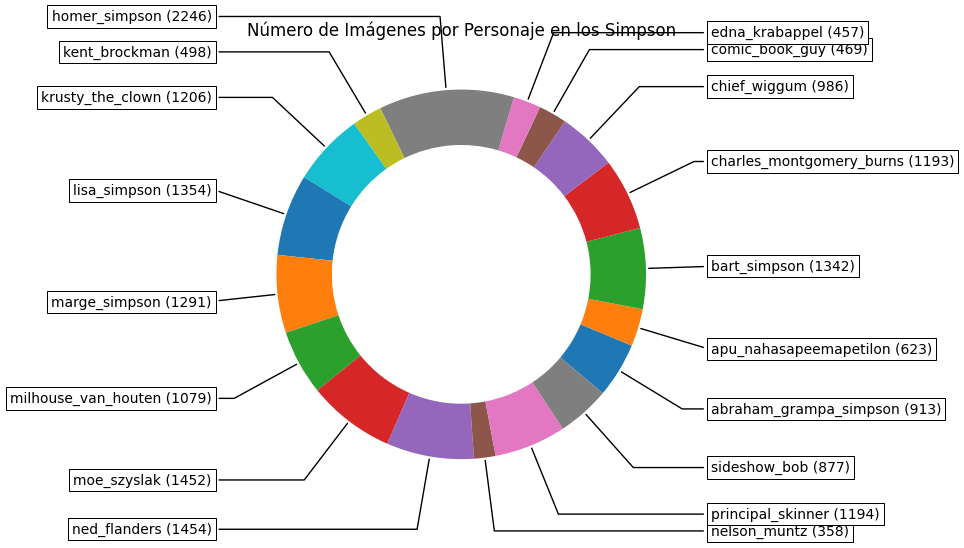

In [13]:
mostrar_grafica_imagenes_train(images_info=images_info)

In [14]:
DATASET_TEST_PATH_COLAB = "C:/Users/denis-zelaya/.keras/datasets/simpsons_testset"
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leídas 890 imágenes de test


In [15]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

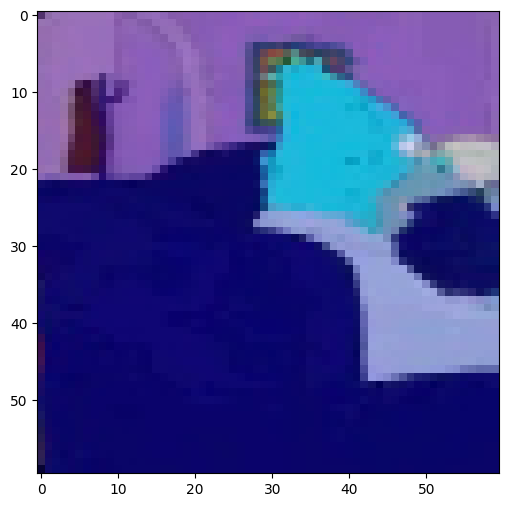

In [16]:
plt.imshow(X_t[2])

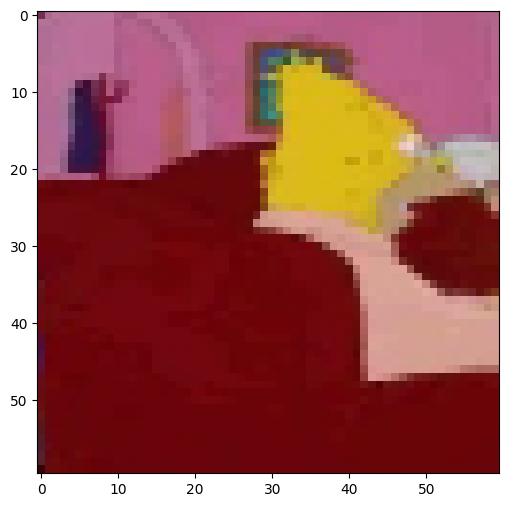

In [17]:
plt.imshow(np.flip(X_t[2], axis=-1) ) 

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

> Analisis de las imagenes cargadas

In [18]:
print("Dimensiones: (Alto, Ancho, No. Canales) ", X_t[0].shape)
print("Valor máximo de los píxeles en las imágenes cargadas: ", X_t.max())
print("Total de Categorias: ", len(MAP_CHARACTERS))

Dimensiones: (Alto, Ancho, No. Canales)  (60, 60, 3)
Valor máximo de los píxeles en las imágenes cargadas:  255
Total de Categorias:  18


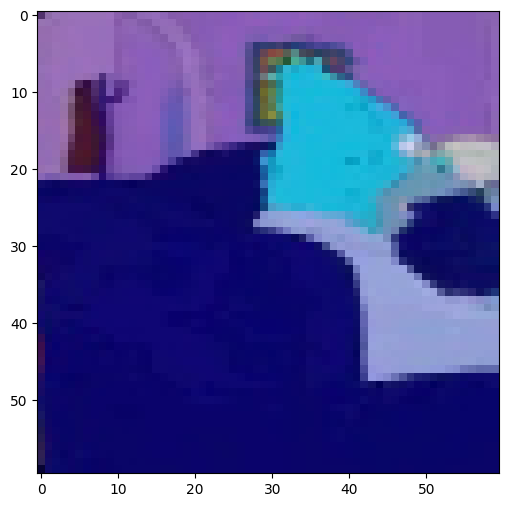

In [19]:
import numpy as np
np.set_printoptions(linewidth=200)
import matplotlib.pyplot as plt
plt.imshow(X_t[2], cmap="gray")


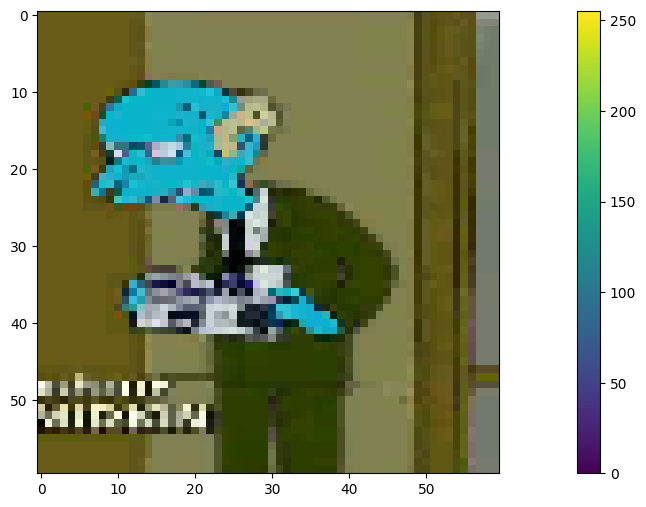

In [20]:
plt.figure()
plt.imshow(X[2])
plt.colorbar() # Agregar una barra de colores a la derecha de la imagen para indicar la escala de colore
plt.grid(False)
plt.show()

### Tenemos el dataset de imagenes y los nombres correspondientes, pero requerimos visualmente inspeccionar las imagenes con sus etiqueras para verificar que esten correctamente etiquetados

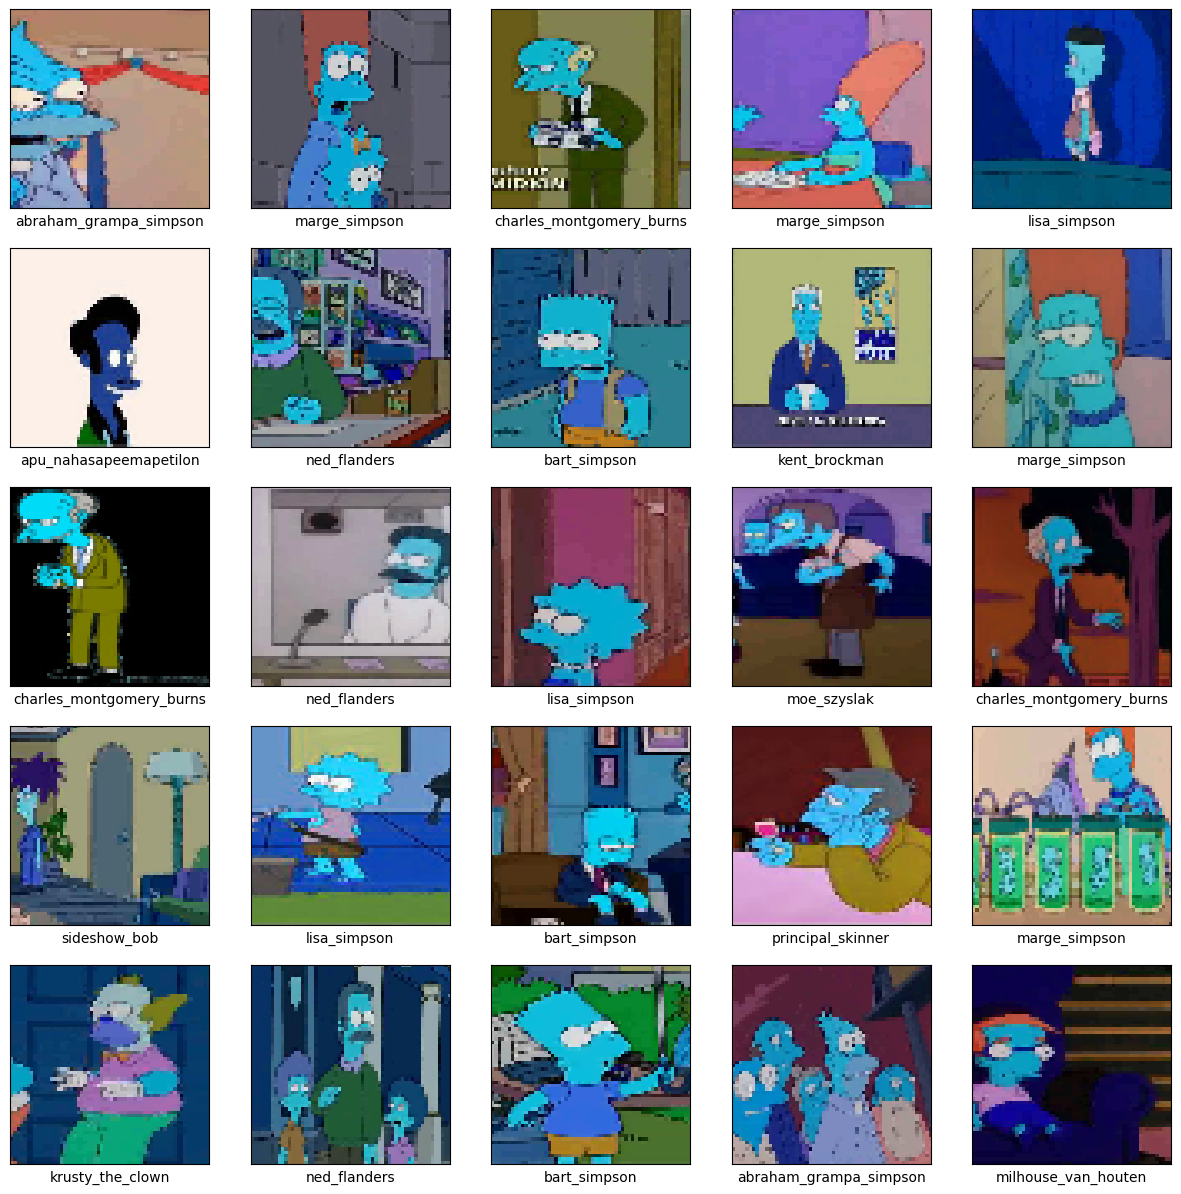

In [21]:

plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[i], cmap=plt.cm.binary)
    plt.xlabel(MAP_CHARACTERS[y[i]])
plt.show()

In [22]:
# Normalización de Datos
X = X / 255.0
X_t = X_t / 255.0

### Preparacion de modelos

In [23]:
import sklearn
import sklearn.preprocessing

num_categories = len(MAP_CHARACTERS)

label_encoder = sklearn.preprocessing.LabelEncoder()

# Codificacion de datos
y_train = label_encoder.fit_transform(y)
y_test = label_encoder.fit_transform(y_t)

# Categorias
y_train_tf = tf.keras.utils.to_categorical(y_train, num_categories)
y_test_tf = tf.keras.utils.to_categorical(y_test, num_categories)

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

import tensorflow as tf

import collections

from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

In [25]:
# CONSTRUCCIÓN DEL MODELO CON REDES NEURONALES CONVULCIONALES
from tensorflow import keras

input_shape = (64, 64, 3)
batch_size = 128
num_classes = 18
epochs = 15

model = keras.models.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same')) 
model.add(keras.layers.Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(keras.layers.Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(keras.layers.Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                        

In [26]:
tf.__version__

'2.10.1'

In [27]:
physical_devices = tf.config.list_physical_devices()
physical_devices

# Imprimir los dispositivos físicos
print("Dispositivos físicos disponibles:")
for device in physical_devices:
    print(device)

# Lista de dispositivos visibles y sus atributos
print("\nDetalles de los dispositivos visibles:")
for device in physical_devices:
    print(device.name, device.device_type)

# Verificar si TensorFlow está utilizando GPU
print("\nDispositivos utilizados por TensorFlow:")
for device in tf.config.list_logical_devices():
    print(device)

Dispositivos físicos disponibles:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

Detalles de los dispositivos visibles:
/physical_device:CPU:0 CPU

Dispositivos utilizados por TensorFlow:
LogicalDevice(name='/device:CPU:0', device_type='CPU')


In [28]:
!cuda-smi

"cuda-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [29]:
!export CUDA_VISIBLE_DEVICES=0  # Reemplaza con el número de tu GPU si es diferente
!cuda-smi

"export" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"cuda-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [30]:
 # COMPILACIÓN DEL MODELO 

 # Para la compilación del modelo, se emplean las métricas: pérdida (loss) y precisión (accuracy)

 model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
# ENTRENAMIENTO DE MODELO

# Para el entrenamiento del modelo se usó 40 épocas con las  que se alcanzó una precisión mayor al 80%

history = model.fit(X,y_train_tf, validation_steps=3, verbose=1,epochs=40, batch_size=1000,validation_split=0.2) 

Epoch 1/40


ValueError: in user code:

    File "c:\Users\denis-zelaya\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\denis-zelaya\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\denis-zelaya\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\denis-zelaya\anaconda3\envs\my_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\denis-zelaya\anaconda3\envs\my_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\denis-zelaya\anaconda3\envs\my_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 60, 60, 3)


In [ ]:
# VALIDACIÓN DEL MODELO

## La evaluación del modelo se lo realiza con los datos de validación y las métricas de pérdida y precisión

test_loss, test_acc = model.evaluate(X_t,  y_test_tf)

print("------------------------------")
print("Métricas de validación")
print("------------------------------")
print("Pérdida:",test_loss)
print( "Precisión:",test_acc)

28/28 [==============================] - 1s 17ms/step - loss: 5.7510 - accuracy: 0.7539
------------------------------
Métricas de validación
------------------------------
Pérdida: 5.751023769378662
Precisión: 0.7539325952529907


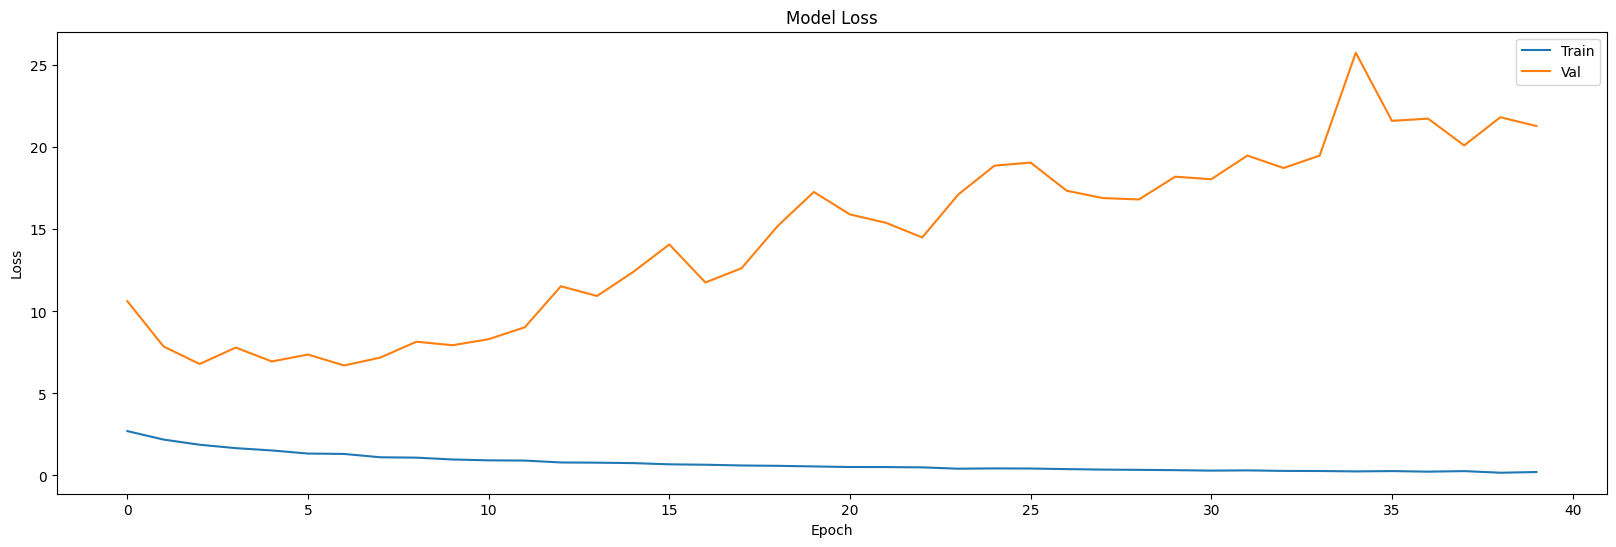

In [ ]:
    
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

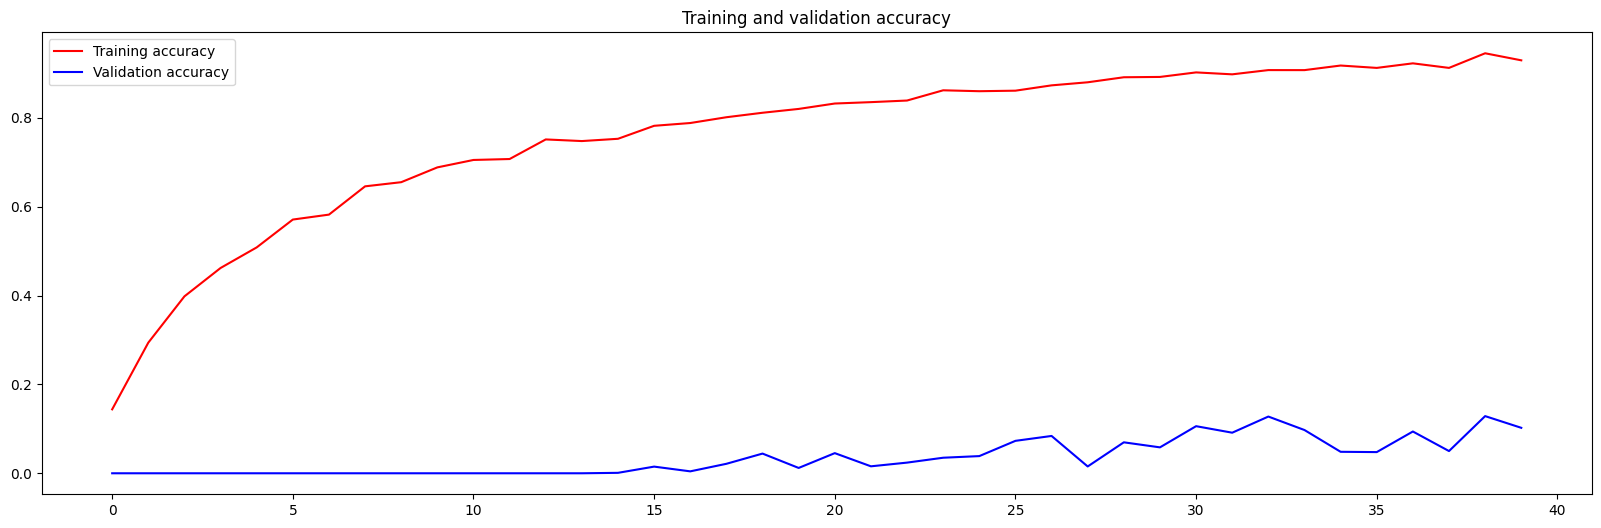

<Figure size 2000x600 with 0 Axes>

In [ ]:
# Meticas de precicion
# GRÁFICO DE LA PRECISIÓN CON DATOS DE ENTRENAMIENTO Y DE VALIDACIÓN

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

https://www.tensorflow.org/tutorials/images/cnn?hl=es-419

In [ ]:
# PREDICCIONES

# Se aplica el modelo para los datos de validación
predictions = model.predict(X_t)

28/28 [==============================] - 1s 12ms/step


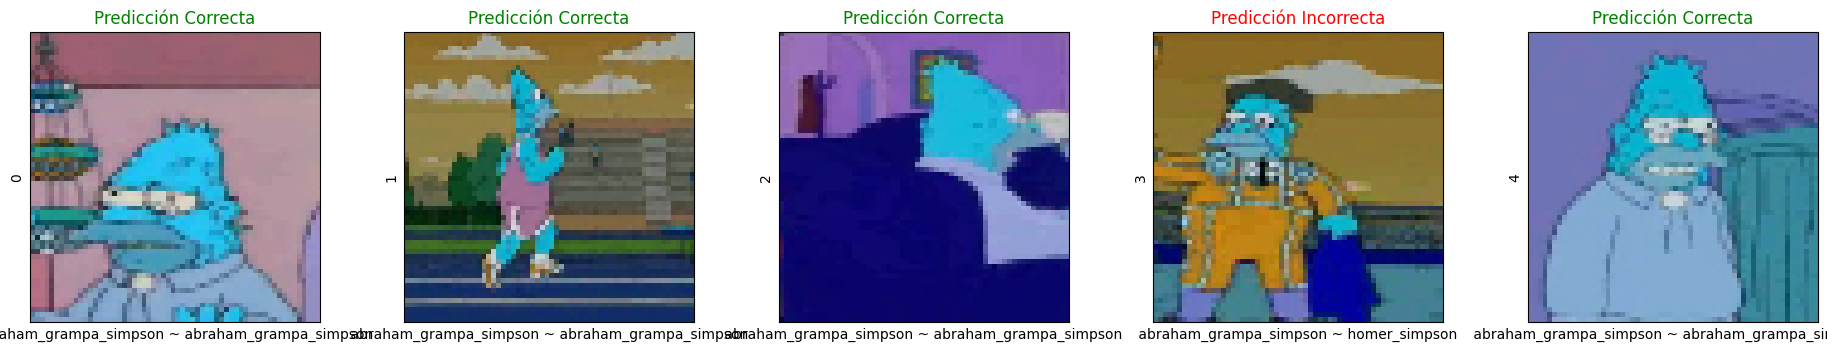

In [ ]:
# GRÁFICO PARA PREDICCIONES

# Se realiza un gráfico para las predicciones en el cual se indica si la clasificación es correcta o no.

plt.figure(figsize=(30, 10))
i = 0
while i < 5:
    image, actual_label = X_t[i], y_t[i]
    predicted_label = np.argmax(predictions[i])
    plt.subplot(3, 8, i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
        
    plt.imshow(image)
    
    if predicted_label == actual_label: 
      color, label = ('green', "Predicción Correcta")
    else:
      color, label = ('red', "Predicción Incorrecta") 
  
    plt.title(label, color=color)
      
    plt.xlabel(" {} ~ {} ".format(
        MAP_CHARACTERS[actual_label],
      MAP_CHARACTERS[predicted_label]))
       
    plt.ylabel(i)
   
    i += 1

In [ ]:
# MATRIZ DE CONFUSIÓN
# Creación de la matriz de confusión
from sklearn.metrics import confusion_matrix
import numpy as np

confusion = confusion_matrix(y_t, np.argmax(predictions,axis=1))
confusion

array([[41,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 47,  0,  0,  0,  0,  2,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 49,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 47,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 48,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0, 49,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 49,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 49,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  1,  0,  0,  1,  3,  0,  0, 38,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, 49,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 

C:\Users\denis-zelaya\AppData\Local\Temp\ipykernel_28020\775317785.py:3: RuntimeWarning: divide by zero encountered in divide
  confusion = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]
C:\Users\denis-zelaya\AppData\Local\Temp\ipykernel_28020\775317785.py:3: RuntimeWarning: invalid value encountered in divide
  confusion = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]


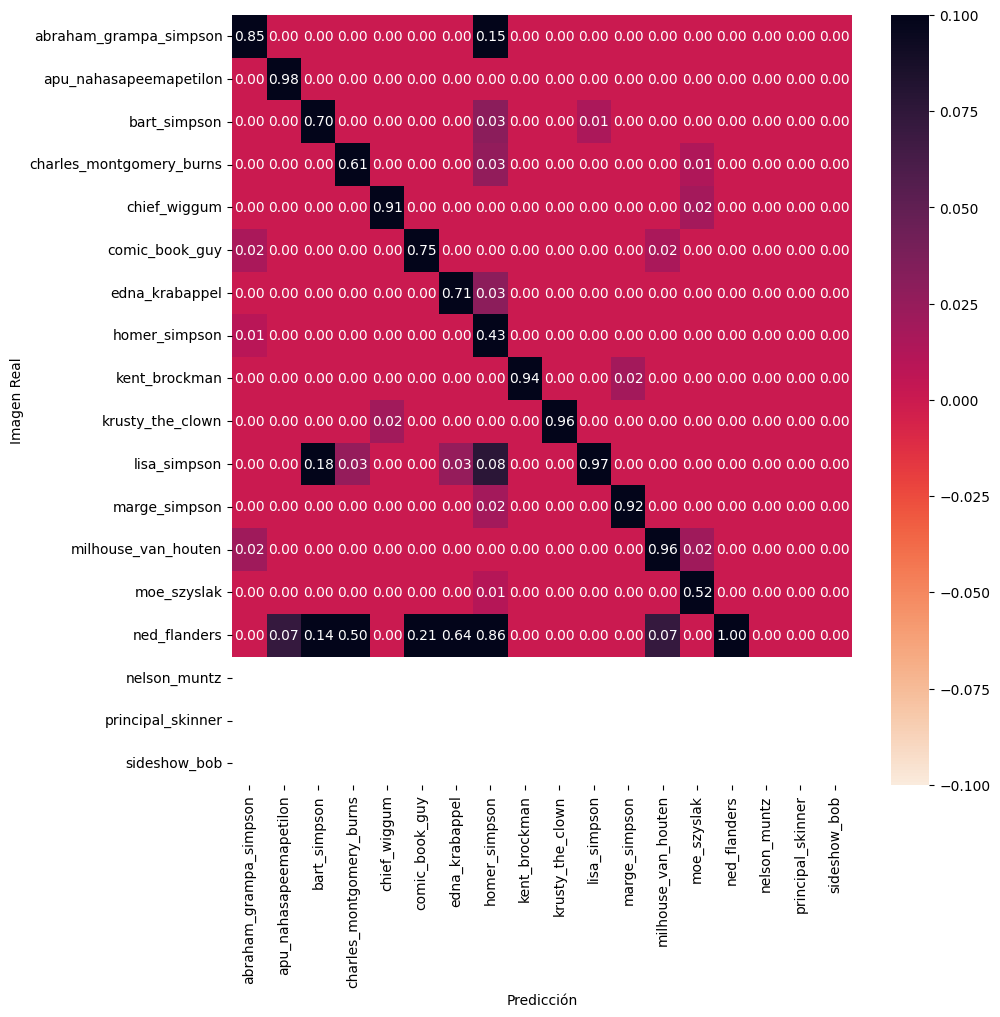

In [ ]:
import seaborn as sns
# normalize the matrix to be in percentages
confusion = confusion.astype('float') / confusion.sum(axis=0)[:, np.newaxis]
# make a plot for the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion, annot=True, fmt='.2f', 
            xticklabels=[MAP_CHARACTERS[c] for c in MAP_CHARACTERS], 
            yticklabels=[MAP_CHARACTERS[c] for c in MAP_CHARACTERS],
            # cmap="Blues"
            cmap="rocket_r"
            )
plt.ylabel('Imagen Real')
plt.xlabel('Predicción')
# plot the resulting confusion matrix
plt.savefig("confusion-matrix.png")
# plt.show()

In [ ]:
import os
from pathlib import Path

# Obtener el directorio del Notebook actual
notebook_path = Path().resolve()

# Imprimir el directorio del Notebook para verificar
print(f"Directorio del Notebook: {notebook_path}")

# Cambiar el directorio de trabajo al directorio del Notebook
os.chdir(notebook_path)

# Ejecutar pipreqs para generar el archivo requirements.txt
!pipreqs . --force

Directorio del Notebook: C:\Users\denis-zelaya\Documents\GitHub\PLN-ACT2\Act2


INFO: Not scanning for jupyter notebooks.
INFO: Successfully saved requirements file in .\requirements.txt


In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,     
        vertical_flip=False)

In [ ]:
datagen.fit(X_train)
    
history = model.fit_generator(datagen.flow(X,Y, batch_size=batch_size),
                              steps_per_epoch=len(X) / 32, 
                              epochs=epochs,validation_data=(X_t, Y),
                              nb_val_samples=0.2)

# evalua los indicadores de loss y accuracy
score = model.evaluate(X_t,Y, verbose=0)
print('\nKeras CNN - accuracy:', score[1])
print('')

# genera las salidas predichas para los ejemplo de ingreso
y_pred = model.predict(X_test)
print('\n', metrics.classification_report(
    np.where(Y_test > 0)[1], np.argmax(y_pred, axis=1), 
    target_names=list(MAP_CHARACTERS.values())), sep='') 

Y_pred_classes = np.argmax(y_pred, axis = 1) 
Y_true = np.argmax(Y_test, axis = 1)

NameError: name 'X_train' is not defined